Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age', 'spent', 'children', 'family_size', 'living_with', 'is_parent',
       'education2', 'customer_for'],
      dtype='object')
0
       Variable  Moyenne  Médiane  Minimum  Maximum
0           age    56.10     55.0       29       85
1         spent   605.74    396.0        5     2525
2   family_size     2.60      3.0        1        5
3  customer_for   353.79    356.0        0      699


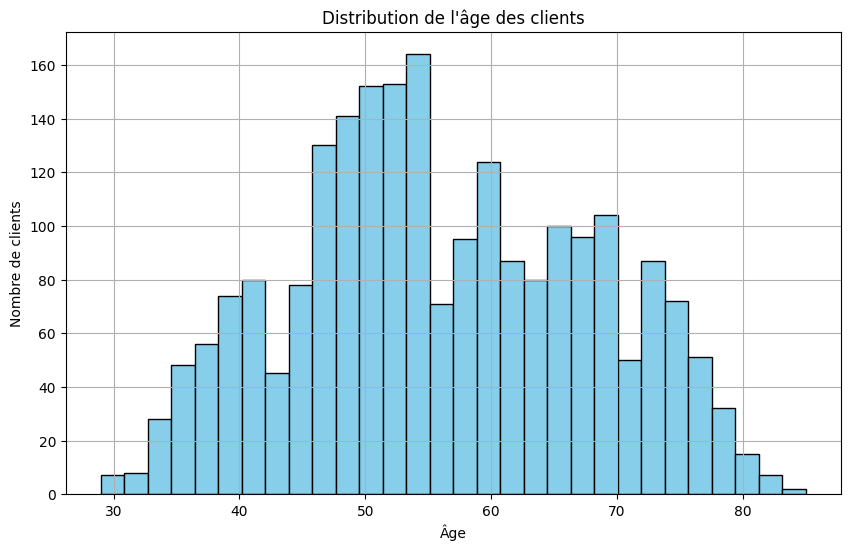

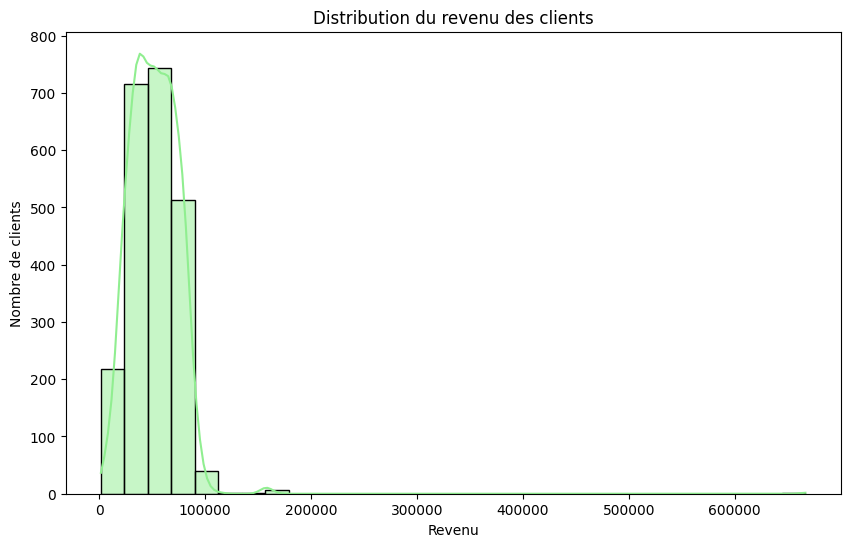

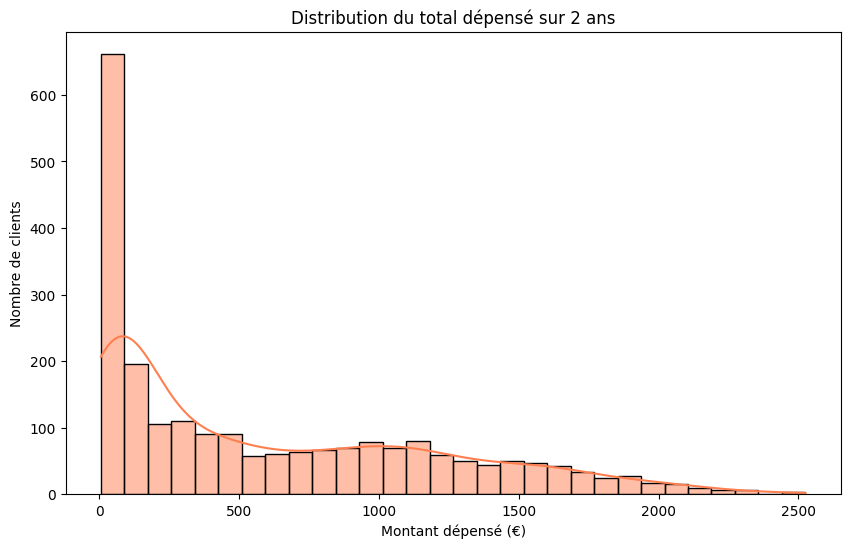

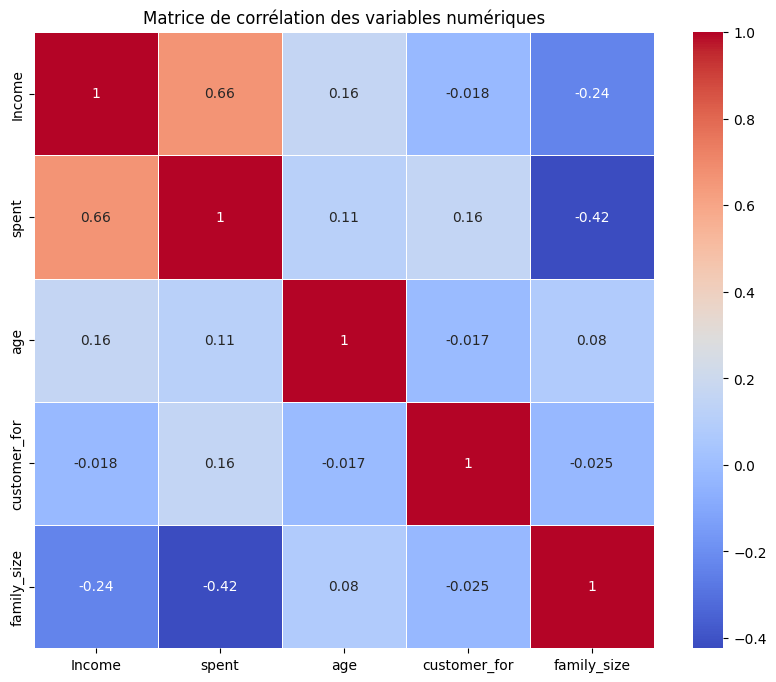

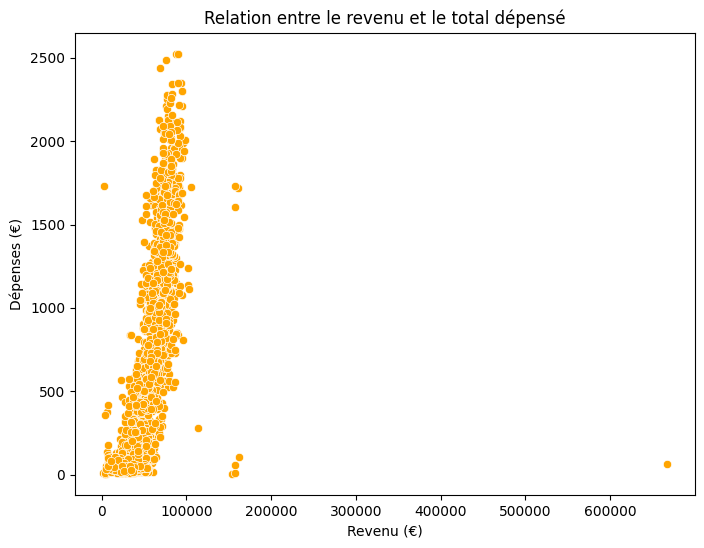

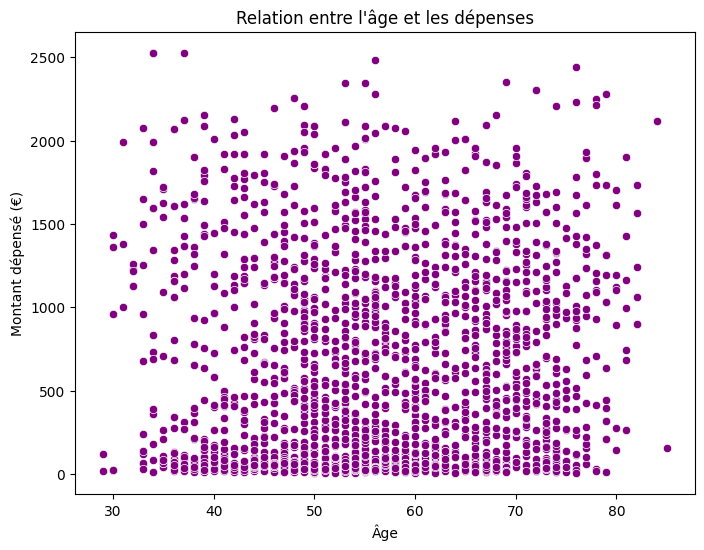

In [ ]:



import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("Market.xlsx", sheet_name="Market")
print(df.columns)

imputer = SimpleImputer(strategy='mean')
df[['Income']] = imputer.fit_transform(df[['Income']])

print(df['Income'].isnull().sum())
df.to_excel("Market_filled.xlsx", index=False)

variables = ['age', 'spent', 'family_size', 'customer_for']

stats = {
    'Variable': [],
    'Moyenne': [],
    'Médiane': [],
    'Minimum': [],
    'Maximum': []
}
for var in variables:
    stats['Variable'].append(var)
    stats['Moyenne'].append(round(df[var].mean(), 2))
    stats['Médiane'].append(round(df[var].median(), 2))
    stats['Minimum'].append(round(df[var].min(), 2))
    stats['Maximum'].append(round(df[var].max(), 2))

summary_df = pd.DataFrame(stats)

print(summary_df)
summary_df.to_excel("Tableau_Analyse_Descriptive.xlsx", index=False)

#Age
plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution de l'âge des clients")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.show()

#Revenu
plt.figure(figsize=(10,6))
sns.histplot(df['Income'], bins=30, kde=True, color='lightgreen')
plt.title("Distribution du revenu des clients")
plt.xlabel("Revenu")
plt.ylabel("Nombre de clients")
plt.show()

#Dépenses (spent)
plt.figure(figsize=(10,6))
sns.histplot(df['spent'], bins=30, kde=True, color='coral')
plt.title("Distribution du total dépensé sur 2 ans")
plt.xlabel("Montant dépensé (€)")
plt.ylabel("Nombre de clients")
plt.show()

#Corrélations
plt.figure(figsize=(10,8))
corr = df[['Income', 'spent', 'age', 'customer_for', 'family_size']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

#Revenu vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='spent', data=df, color='orange')
plt.title("Relation entre le revenu et le total dépensé")
plt.xlabel("Revenu (€)")
plt.ylabel("Dépenses (€)")
plt.show()


#Âge vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='spent', data=df, color='purple')
plt.title("Relation entre l'âge et les dépenses")
plt.xlabel("Âge")
plt.ylabel("Montant dépensé (€)")
plt.show()





FONCTIONS EDA et Matrice de Corrélation

In [ ]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Fonctions utilitaires ---
def detect_sep(path: Path) -> str:
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = [f.readline() for _ in range(5)]
    candidates = [",", ";", "\t", "|"]
    best, best_count = ",", -1
    for sep in candidates:
        c = sum(line.count(sep) for line in lines if line)
        if c > best_count:
            best_count, best = c, sep
    return best

def ensure_dir(d: Path) -> Path:
    d.mkdir(parents=True, exist_ok=True)
    return d

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def save_table(df: pd.DataFrame, outdir: Path, name: str):
    p = outdir / f"{name}.csv"
    df.to_csv(p, index=False)
    print(f"[CSV] {p}")
    return p

def save_fig(outdir: Path, name: str):
    p = outdir / f"{name}.png"
    plt.tight_layout()
    plt.savefig(p, dpi=140)
    print(f"[PNG] {p}")
def simplify_marital_status(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    return "couple" if x in {"married","together","union","in relationship"} else "célibataire"

def simplify_education(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    if x in {"master","phd","postgraduate"}: return "postgrad"
    if x in {"graduation","graduate","college","bachelor"}: return "grad"
    return "undergrad"

def add_missing_features(df: pd.DataFrame) -> pd.DataFrame:
    if "Dt_Customer" in df.columns:
        df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce", dayfirst=True)
    if "age" not in df.columns and "Year_Birth" in df.columns:
        df["age"] = 2025 - to_num(df["Year_Birth"])
    if "spent" not in df.columns:
        mnt_cols = [c for c in df.columns if c.lower().startswith("mnt")]
        if mnt_cols:
            df["spent"] = df[mnt_cols].apply(to_num).sum(axis=1)
    if "living_with" not in df.columns and "Marital_Status" in df.columns:
        df["living_with"] = df["Marital_Status"].apply(simplify_marital_status)
    if "education2" not in df.columns and "Education" in df.columns:
        df["education2"] = df["Education"].apply(simplify_education)
    if "is_parent" not in df.columns and {"Kidhome","Teenhome"}.issubset(df.columns):
        df["children"] = to_num(df["Kidhome"]).fillna(0) + to_num(df["Teenhome"]).fillna(0)
        df["is_parent"] = (df["children"] > 0).astype(int)
    if "Response" in df.columns and not pd.api.types.is_numeric_dtype(df["Response"]):
        df["Response"] = to_num(df["Response"])
    return df

# --- Matrice de corrélation ---
def show_corr_heatmap(df_num, outdir: Path, fname: str):
    if df_num.shape[1] < 2:
        print("[INFO] Pas assez de colonnes numériques pour la corrélation.")
        return None
    corr = df_num.corr()
    plt.figure(figsize=(12, 8))
    plt.imshow(corr.values, aspect='auto', cmap="coolwarm")
    plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)
    plt.title("Matrice de corrélation (numérique)")
    plt.colorbar()
    plt.show()
    return corr


LANCEMENT DE L’ANALYSE EDA

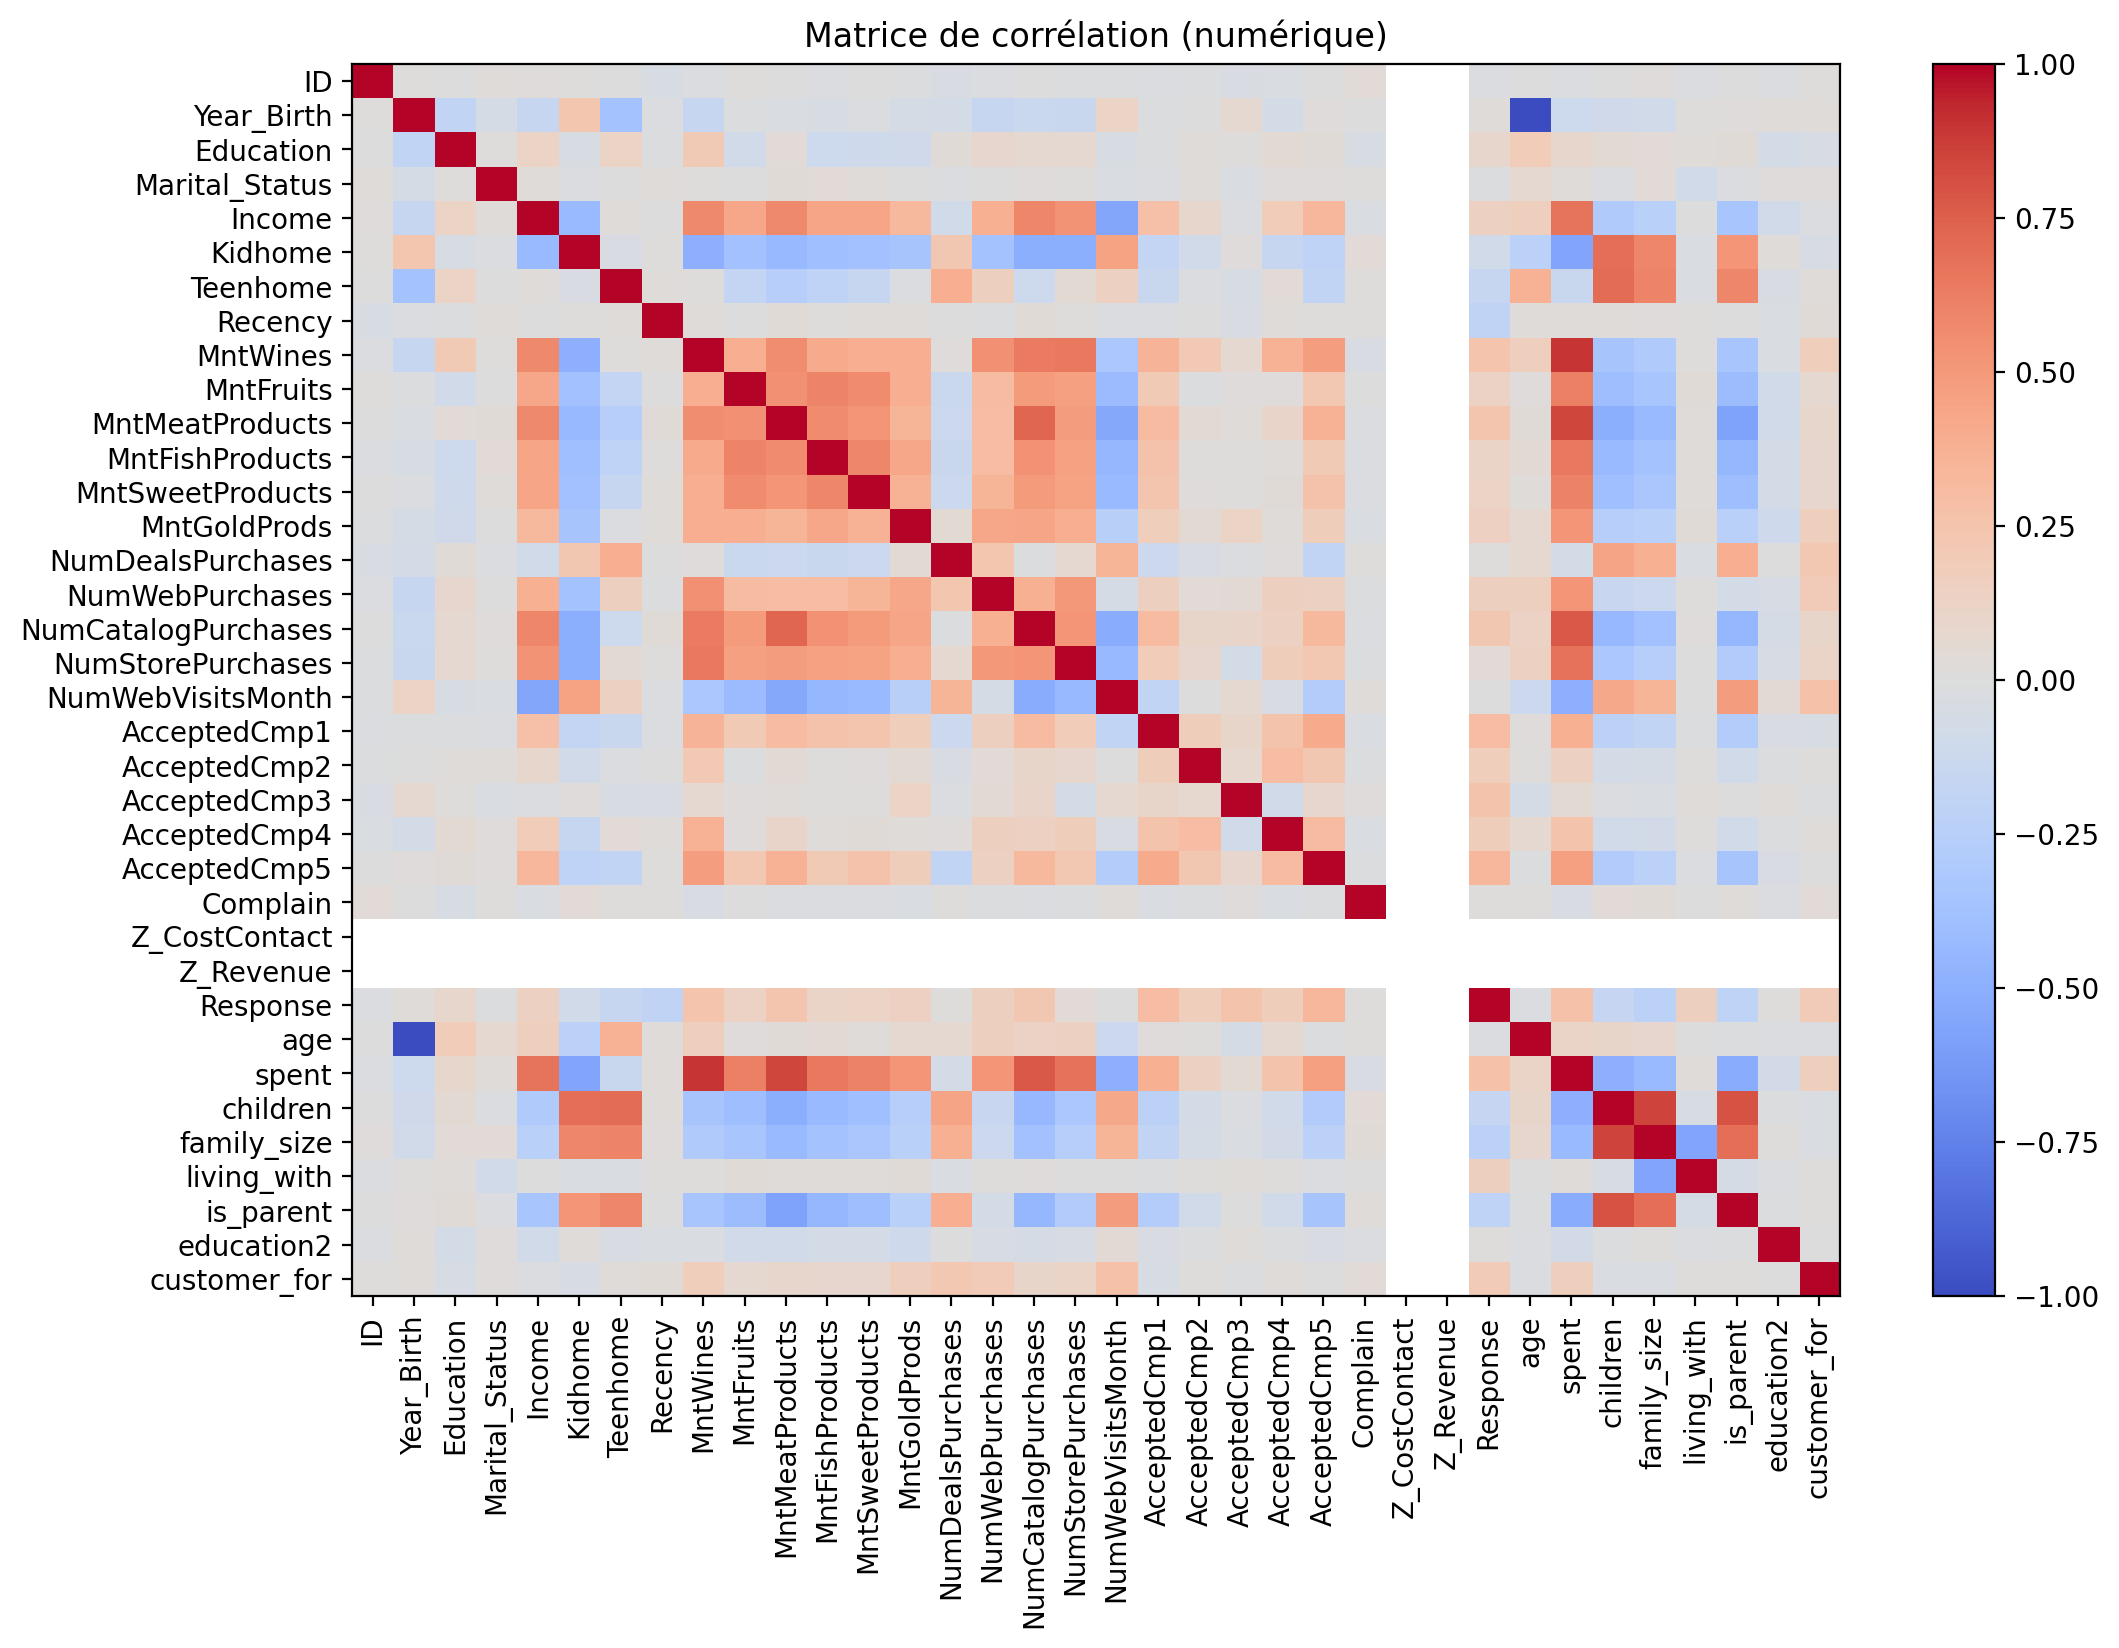

In [ ]:
file_path = Path("Market_filled.xlsx")
df = add_missing_features(df)
outdir = ensure_dir(Path("eda_output"))

corr = show_corr_heatmap(df.select_dtypes(include=np.number), outdir, "heatmap_corr")


Encodage et standardscalerr

In [6]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_excel("Market_filled.xlsx")
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("🔍 Colonnes non numériques détectées :", list(non_numeric_cols))
 
le = LabelEncoder()
for col in non_numeric_cols:
    df[col] = le.fit_transform(df[col].astype(str))
 
print("✅ Colonnes encodées :", list(non_numeric_cols))
cols_to_drop = [
    'ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
    'AcceptedCmp4', 'AcceptedCmp5', 'Response',
    'Z_CostContact', 'Z_Revenue', 'Dt_Customer'  
]
df_scaled = df.drop(columns=cols_to_drop, errors='ignore')
print("Colonnes conservées pour le scaling :", list(df_scaled.columns))
print("Types de données :", df_scaled.dtypes.unique())
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(scaled_data, columns=df_scaled.columns)
df_scaled.to_excel("Camp_Market_encoded_scaled.xlsx", index=False)
 
print("✅ Encodage + Scaling terminés et sauvegardés dans : Camp_Market_encoded_scaled.xlsx")
 
 

🔍 Colonnes non numériques détectées : ['Education', 'Marital_Status', 'living_with', 'education2']
✅ Colonnes encodées : ['Education', 'Marital_Status', 'living_with', 'education2']
Colonnes conservées pour le scaling : ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'age', 'spent', 'children', 'family_size', 'living_with', 'is_parent', 'education2', 'customer_for']
Types de données : [dtype('int64') dtype('float64')]
✅ Encodage + Scaling terminés et sauvegardés dans : Camp_Market_encoded_scaled.xlsx
